<a href="https://colab.research.google.com/github/mohamedghaly1/ECG-Detection-Using-EGRU/blob/main/LSTM%20and%20GRU%20models/LSTM_GRU_model_ECG_ARRHYHMIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/kaggle_dataset'

In [ ]:
%cd /content/gdrive/MyDrive/kaggle_dataset/

/content/gdrive/MyDrive/kaggle_dataset


In [ ]:
!ls

kaggle.json


In [ ]:
!kaggle datasets download -d shayanfazeli/heartbeat

Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
 96% 95.0M/98.8M [00:00<00:00, 201MB/s]
100% 98.8M/98.8M [00:00<00:00, 193MB/s]


In [ ]:
!mkdir heartbeat
!mv heartbeat.zip heartbeat

In [ ]:
%cd heartbeat/

/content/gdrive/MyDrive/kaggle_dataset/heartbeat


In [ ]:
!unzip heartbeat.zip

Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [ ]:
%cd /content

/content


In [ ]:
!pip install eco2ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.5.0 requires pandas>=1.5.0, but you have pandas 1.4.3 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.4.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.4.3 which is incompatible.
plotnine 0.12.4 requires pandas>=1.5.0, but you have pandas 1.4.3 whic

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import eco2ai
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Preprocessing & Exploring The Data

In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_train.csv",header=None)
test_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_test.csv",header=None)
print(train_df[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


**Sampling**

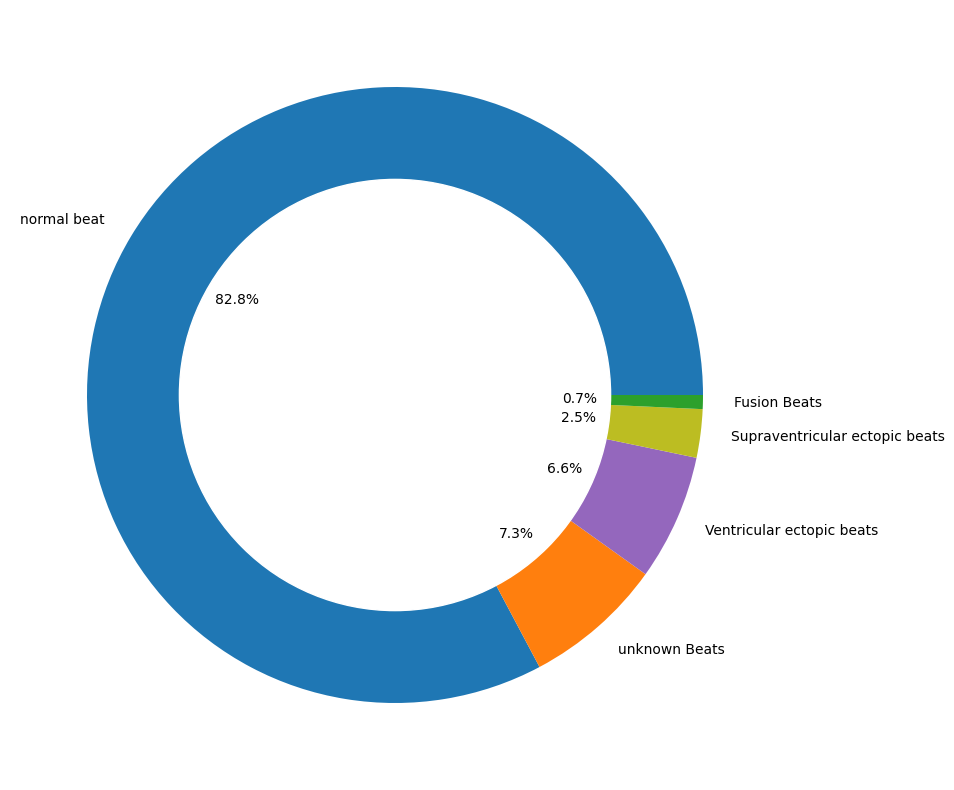

In [ ]:
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

**Oversampling / SMOTE Sampling**

In [ ]:
from sklearn.utils import resample
df_1=train_df [train_df [187]==1]
df_2=train_df [train_df [187]==2]
df_3=train_df [train_df[187]==3]
df_4=train_df [train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=65000,random_state=42)
train_df=pd.concat([df_0,df_1,df_2,df_3,df_4])

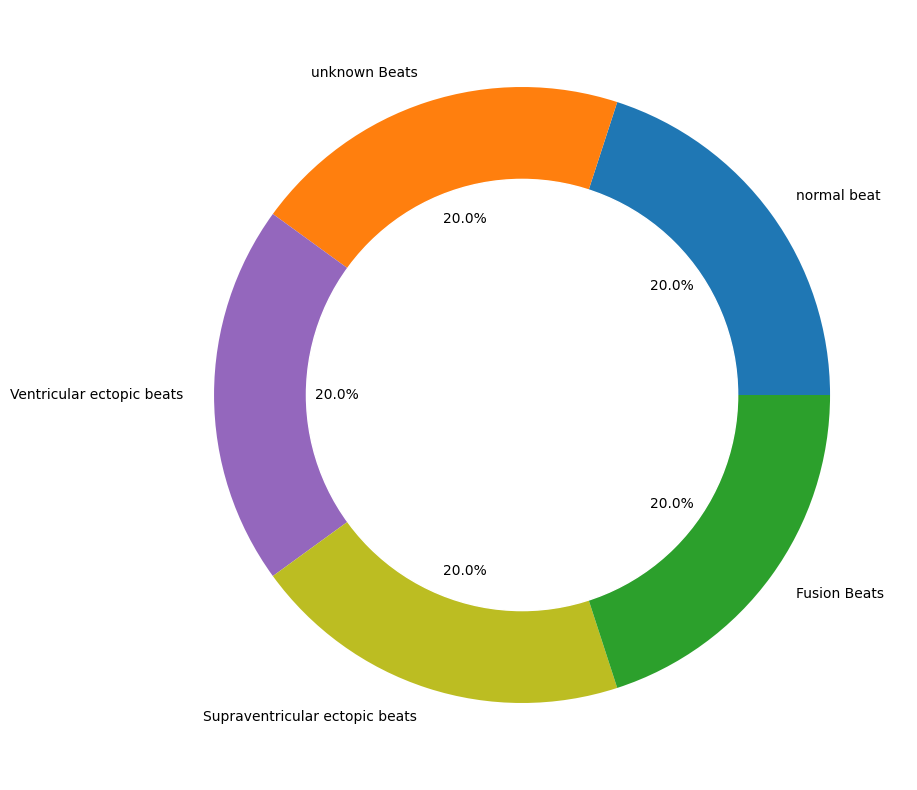

0.0    65000
1.0    65000
2.0    65000
3.0    65000
4.0    65000
Name: 187, dtype: int64


In [ ]:
# Separate features and target variable
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate the resampled data
train_df = pd.DataFrame(X_resampled)
train_df[187] = y_resampled

per_class = train_df[187].value_counts()
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat', 'unknown Beats', 'Ventricular ectopic beats', 'Supraventricular ectopic beats', 'Fusion Beats'], colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
print(train_df[187].value_counts())

**Plotting**

In [ ]:
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
print("classes:",classes)

classes:              0         1         2         3         4         5         6    \
36798   1.000000  0.873747  0.320641  0.002004  0.154309  0.148297  0.072144   
99935   0.967590  0.833261  0.183672  0.000000  0.084098  0.142099  0.113603   
172993  0.000000  0.029419  0.092766  0.178397  0.241366  0.282052  0.362433   
229861  0.852083  0.861744  0.924418  0.987627  0.938735  0.624525  0.346427   
326582  0.860310  0.515188  0.522370  0.535424  0.541868  0.525285  0.523110   

             7         8         9    ...       178       179       180  \
36798   0.062124  0.068136  0.064128  ...  0.000000  0.000000  0.000000   
99935   0.158336  0.202502  0.182535  ...  0.300435  0.291401  0.294498   
172993  0.407825  0.453398  0.527244  ...  0.000000  0.000000  0.000000   
229861  0.213228  0.160163  0.141835  ...  0.000000  0.000000  0.000000   
326582  0.468188  0.377144  0.265906  ...  0.000000  0.000000  0.000000   

             181       182       183       184       185   

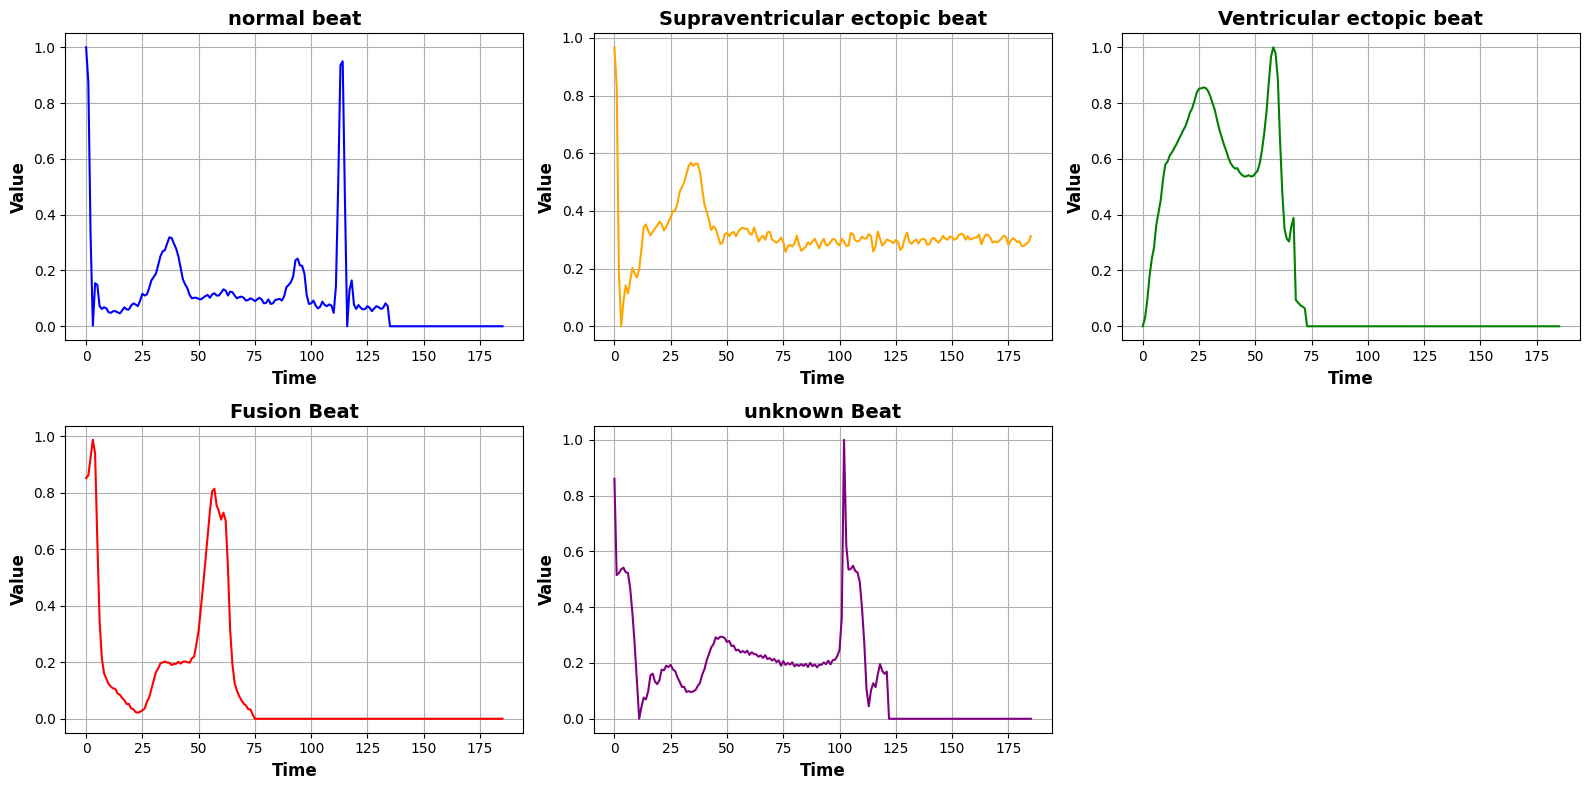

In [ ]:
# Define custom colors for each class
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(16, 8))

class_labels = ['normal beat', 'Supraventricular ectopic beat', 'Ventricular ectopic beat',
                'Fusion Beat','unknown Beat']

for i, label in enumerate(class_labels, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(data=classes.iloc[i-1, :186], color=colors[i-1])
    plt.title(label, fontsize=14, fontweight='bold')

    # Set labels and ticks
    plt.xlabel('Time', fontsize=12, fontweight='bold')
    plt.ylabel('Value', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

plt.tight_layout()
plt.show()

**Getting the Data**

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

## **Model 1 (using LSTM)**

**LSTM Network**

In [ ]:
def lstm_network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_lstm = Input(shape=(im_shape), name='inputs_lstm')
    lstm1 = LSTM(128, return_sequences=True)(inputs_lstm)
    lstm1 = BatchNormalization()(lstm1)
    lstm2 = LSTM(128, return_sequences=True)(lstm1)
    lstm2 = BatchNormalization()(lstm2)
    lstm3 = LSTM(128)(lstm2)
    lstm3 = BatchNormalization()(lstm3)
    dense_end1 = Dense(64, activation='relu')(lstm3)
    # dense_end1 = Dropout(0.2)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    # dense_end2 = Dropout(0.2)(dense_end2)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs=inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_lstm.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=20, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model_lstm.h5')
    return model, history


**LSTM Evaluation**

In [ ]:
def lstm_evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

**Initialize eco2ai Tracker for estimating the Power Consumption and CO2 Emission**

In [ ]:
# Initialize eco2ai Tracker with project and experiment description
lstm_tracker = eco2ai.Tracker(project_name="Heartbeat Classification", experiment_description="Training EGRU model for heartbeat classification", file_name="lstm_emission.csv")

**Train the LSTM model**

In [ ]:
lstm_tracker.start()
start_time = time.time()
model,history=lstm_network(X_train,y_train,X_test,y_test)
current_time = time.time()
lstm_tracker.stop()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch 1/20
10157/10157 [==============================] - 267s 26ms/step - loss: 0.3873 - accuracy: 0.8596 - val_loss: 0.1849 - val_accuracy: 0.9476
Epoch 2/20
10157/10157 [==============================] - 264s 26ms/step - loss: 0.1473 - accuracy: 0.9503 - val_loss: 0.2959 - val_accuracy: 0.8990
Epoch 3/20
10157/10157 [==============================] - 287s 28ms/step - loss: 0.1001 - accuracy: 0.9669 - val_loss: 0.3412 - val_accuracy: 0.8809
Epoch 4/20
10157/10157 [==============================] - 292s 29ms/step - loss: 0.0759 - accuracy: 0.9753 - val_loss: 0.1103 - val_accuracy: 0.9684
Epoch 5/20
10157/10157 [==============================] - 284s 28ms/step - loss: 0.0638 - accuracy: 0.9795 - val_loss: 0.2001 - val_accuracy: 0.9368
Epoch 6/20
10157/10157 [==============================] - 276s 27ms/step - loss: 0.0553 - accuracy: 0.9824 - val_loss: 0.1312 - val_accuracy: 0.9629
Epoch 7/20
10157/10157 [==============================] - 279s 27ms/step - loss: 0.0488 - accuracy: 0.9846

**Evaluate the LSTM model**

Accuracy: 98.12%


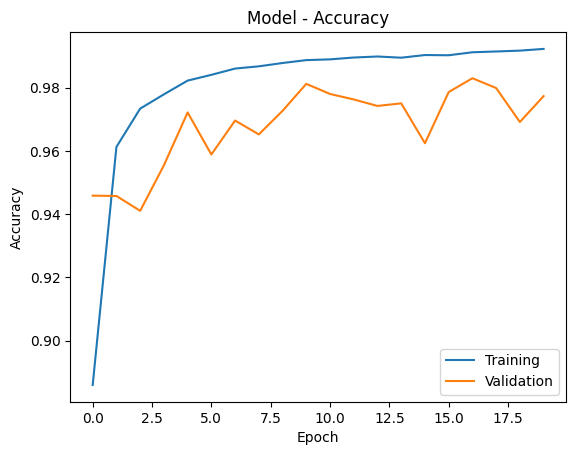

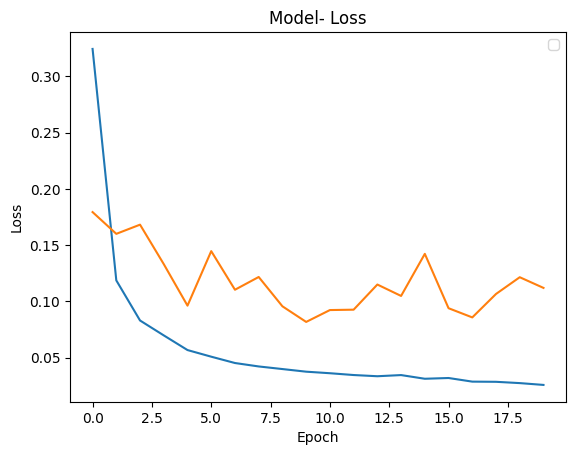

685/685 [==============================] - 6s 9ms/step


In [ ]:
lstm_evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

**Reviewing the Power Consumption and CO2 emission**

In [ ]:
df = pd.read_csv('lstm_emission.csv',sep =',')
df

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,7286ff9b-df9a-4bd0-9d76-da045a0ac1b2,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-05-12 18:05:57,6199.796138,0.383206,0.128508,"Intel(R) Xeon(R) CPU @ 2.00GHz/1 device(s), TD...",Tesla T4 1 device(s),Linux,US/Nevada,0


## **Model 2 (using GRU)**

**GRU Network**

In [ ]:
def gru_network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_gru = Input(shape=(im_shape), name='inputs_gru')
    gru1 = GRU(128, return_sequences=True)(inputs_gru)
    gru1 = BatchNormalization()(gru1)
    gru2 = GRU(128, return_sequences=True)(gru1)
    gru2 = BatchNormalization()(gru2)
    gru3 = GRU(128)(gru2)
    gru3 = BatchNormalization()(gru3)
    dense_end1 = Dense(64, activation='relu')(gru3)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs=inputs_gru, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_gru.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=20, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model_gru.h5')

    return model, history

**GRU Evaluation**

In [ ]:
def gru_evaluate_model(history, X_test, y_test, model):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))

    print(history)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history.history['accuracy'], label='Training')
    sns.lineplot(data=history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history.history['loss'], label='Training')
    sns.lineplot(data=history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate confusion matrix
    y_true = [np.argmax(element) for element in y_test]
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

    # Normalize confusion matrix
    normalized_cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cnf_matrix, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()

In [ ]:
# Initialize eco2ai Tracker with project and experiment description
gru_tracker = eco2ai.Tracker(project_name="Heartbeat Classification", experiment_description="Training EGRU model for heartbeat classification",file_name="gru_emission.csv")

In [ ]:
gru_tracker.start()
start_time = time.time()
model, history = gru_network(X_train, y_train, X_test, y_test)
current_time = time.time()
gru_tracker.stop()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch 1/20
10157/10157 [==============================] - 272s 26ms/step - loss: 0.2279 - accuracy: 0.9190 - val_loss: 0.2611 - val_accuracy: 0.9254
Epoch 2/20
10157/10157 [==============================] - 250s 25ms/step - loss: 0.0887 - accuracy: 0.9705 - val_loss: 0.3085 - val_accuracy: 0.8792
Epoch 3/20
10157/10157 [==============================] - 256s 25ms/step - loss: 0.0639 - accuracy: 0.9788 - val_loss: 0.2265 - val_accuracy: 0.9239
Epoch 4/20
10157/10157 [==============================] - 261s 26ms/step - loss: 0.0541 - accuracy: 0.9824 - val_loss: 0.1173 - val_accuracy: 0.9704
Epoch 5/20
10157/10157 [==============================] - 258s 25ms/step - loss: 0.0476 - accuracy: 0.9845 - val_loss: 0.1419 - val_accuracy: 0.9487
Epoch 6/20
10157/10157 [==============================] - 261s 26ms/step - loss: 0.0439 - accuracy: 0.9855 - val_loss: 0.1461 - val_accuracy: 0.9508
Epoch 7/20
10157/10157 [==============================] - 254s 25ms/step - loss: 0.0426 - accuracy: 0.9863

Accuracy: 97.61%


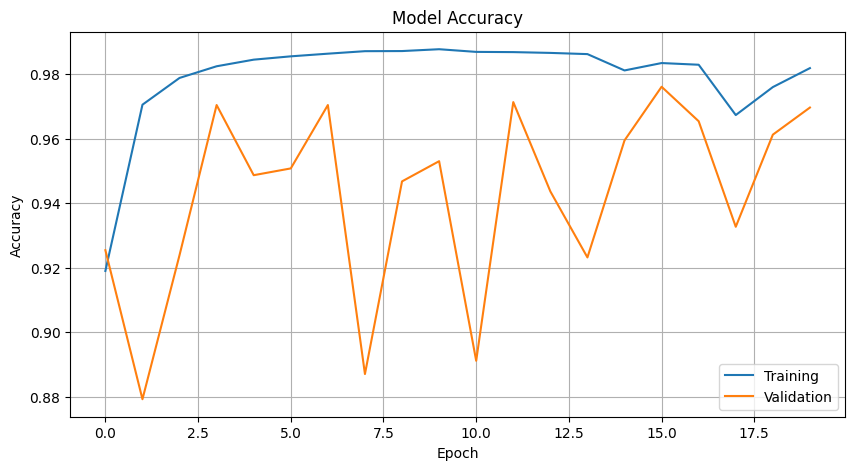

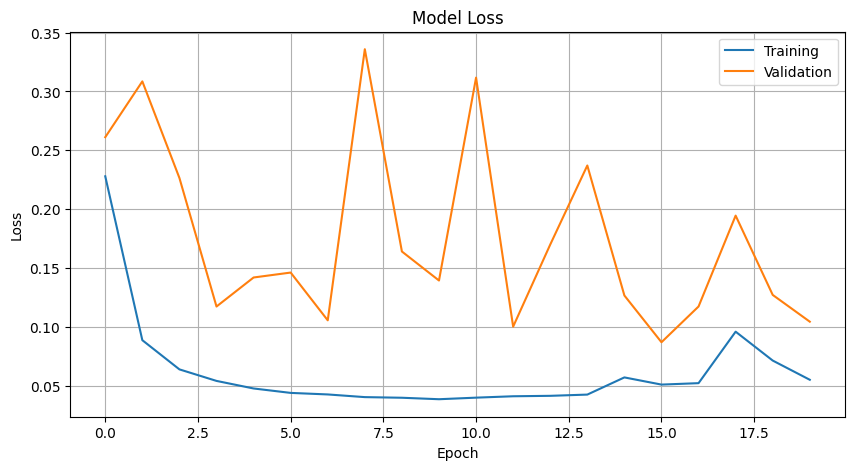

685/685 [==============================] - 7s 9ms/step


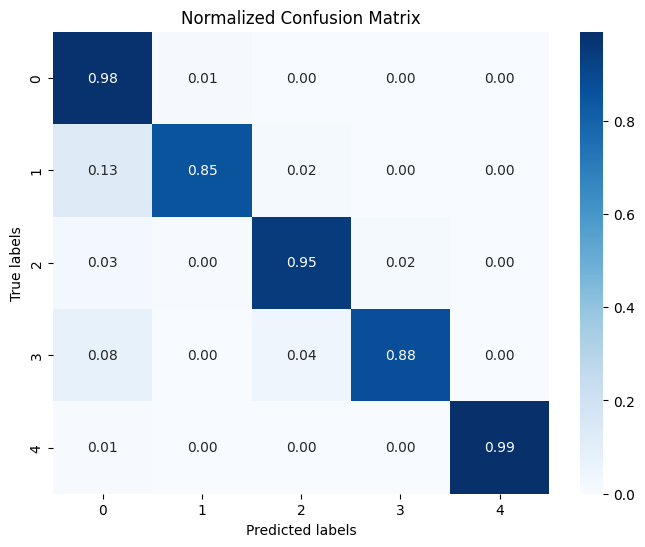

685/685 [==============================] - 6s 9ms/step


In [ ]:
gru_evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [ ]:
df = pd.read_csv('gru_emission.csv',sep =',')
df

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,6ba2d2c5-494b-4831-a284-1efe27c4331e,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-05-16 11:17:47,5189.801332,0.315697,0.105869,"Intel(R) Xeon(R) CPU @ 2.00GHz/1 device(s), TD...",Tesla T4 1 device(s),Linux,US/Nevada,0
